# **Churn Prediction and Analysis**


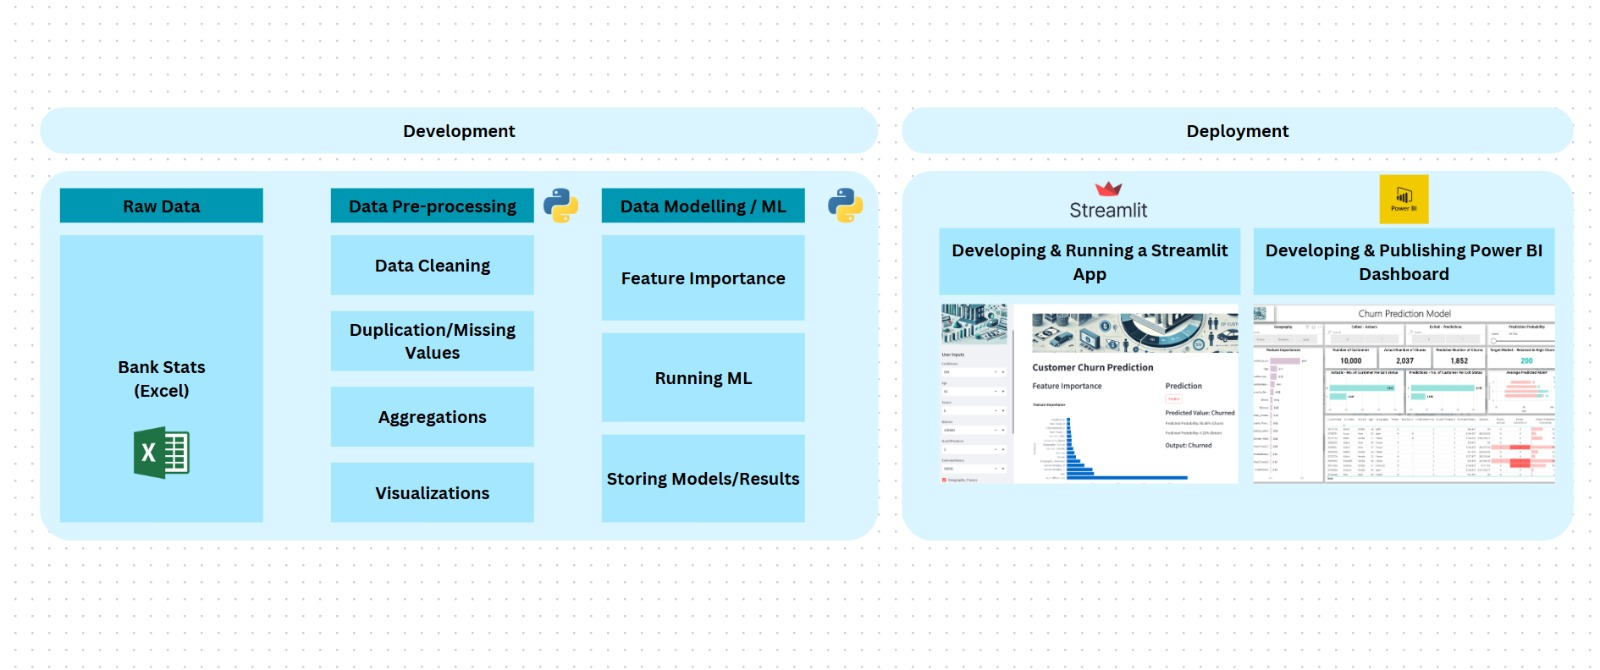

In [3]:
import os
import pandas as pd
from IPython.display import Image
Image("C:/Users/K Saketh/ADM Project/Churn_model.jpg", width=2200, height=1300)


# **Agenda**

1. Problem Formulation
2. Loading the Raw Data from Kaggle
3. Data Pre-processing
4. Running XGBoost
5. Hyperparameter Tuning
6. Storing Models and Results
7. Streamlit App
8. PowerBI Dashboard



# **ML Process**

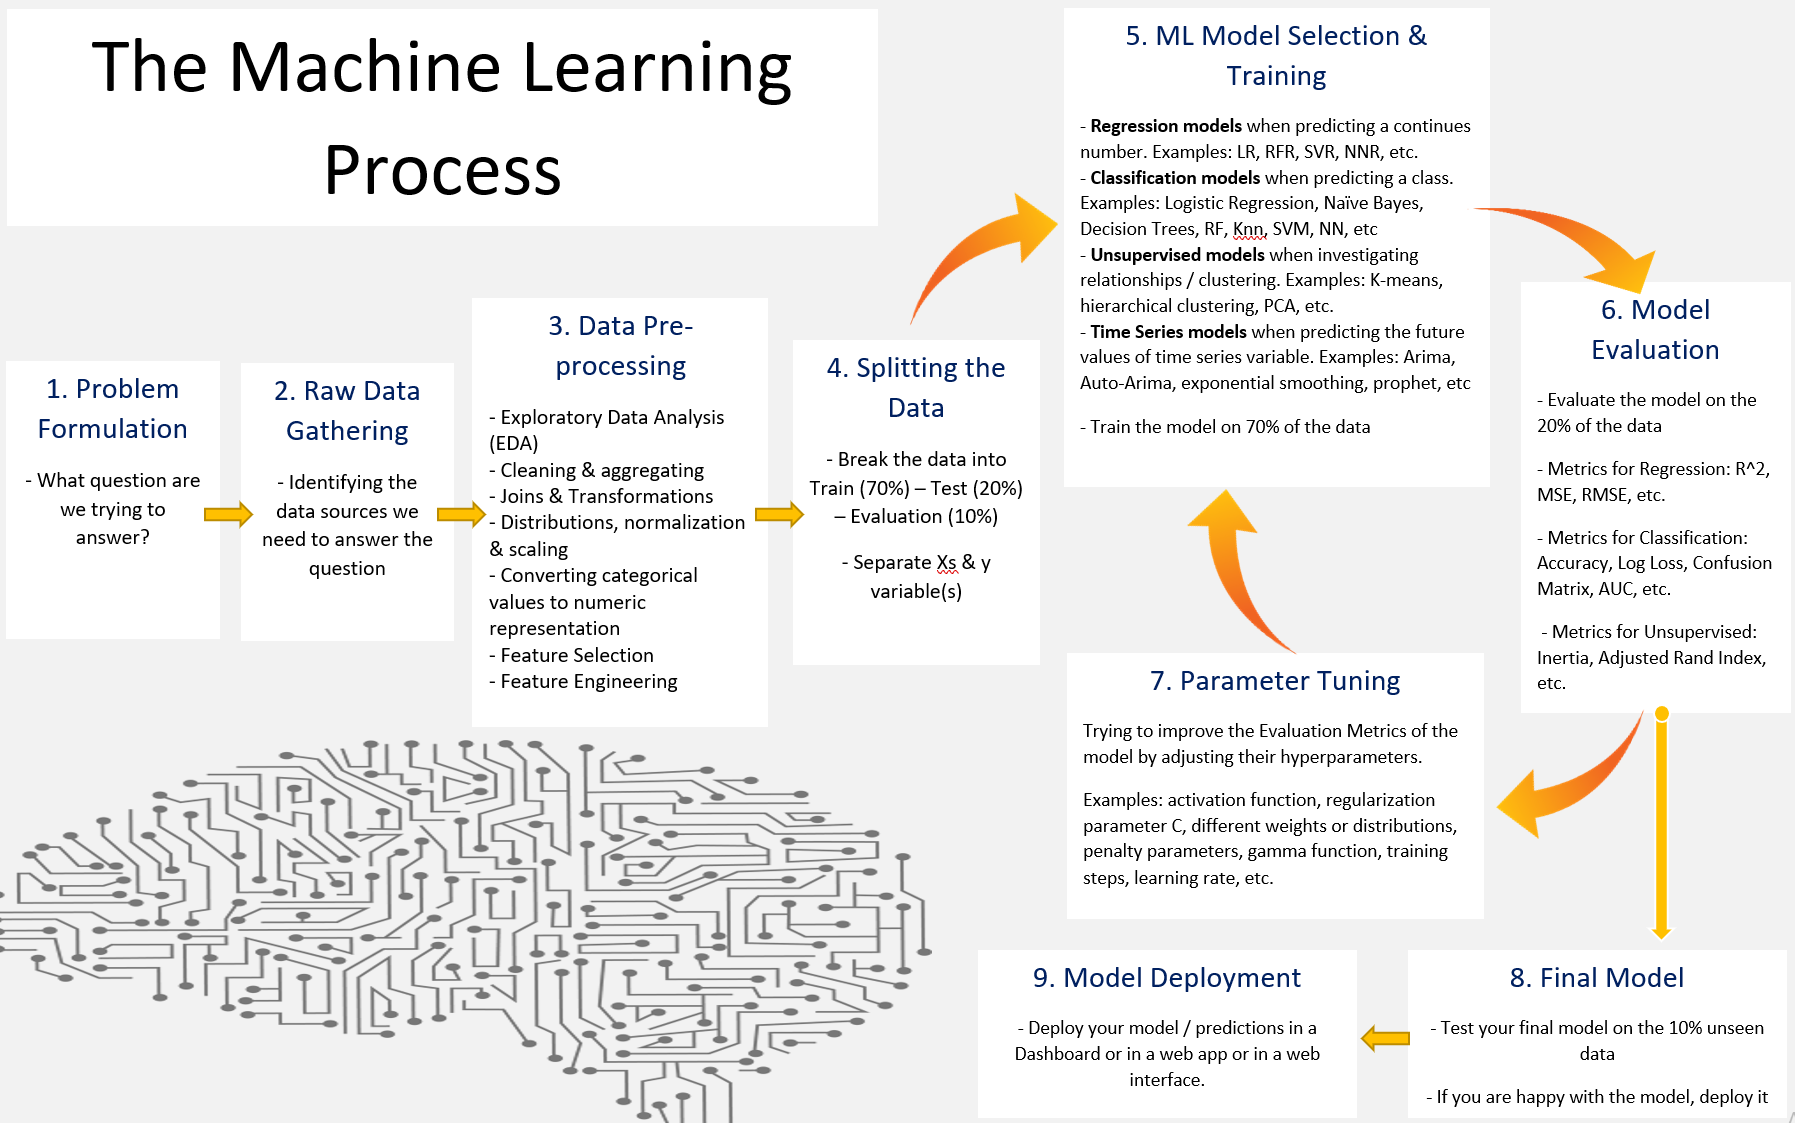

In [8]:
Image("C:/Users/K Saketh/ADM Project/ML Process.png",width=2200, height=1300)

# **1.Problem Formulation**

- Understand which factors influence churn the most
- Identify individuals with high probability of churning
- Build a churn prediction model

# **2. Loading the Raw Data**

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pickle
import plotly.express as px
import streamlit as st
from sklearn.preprocessing import MinMaxScaler
# pip install xgboost
# pip install graphviz

# loading excel
raw_raw = pd.read_csv("C:/Users/K Saketh/ADM Project/Churn_Modelling.csv", encoding="latin1")
# Source: https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset

# to see your directory: os.getcwd()
# pd.set_option('display.max_rows', None) # display all rows
# pd.set_option('display.max_columns', None) # display all columns

raw_raw.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


# **3.Data Pre-Processing**

## 3.1 Understanding the Data 

In [17]:
# Investigate all the elements whithin each Feature 

for column in raw_raw:
    unique_vals = np.unique(raw_raw[column].fillna('0'))
    nr_values = len(unique_vals)
    if nr_values <= 12:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature RowNumber :10000
The number of values for feature CustomerId :10000
The number of values for feature Surname :2932
The number of values for feature CreditScore :460
The number of values for feature Geography :3 -- ['France' 'Germany' 'Spain']
The number of values for feature Gender :2 -- ['Female' 'Male']
The number of values for feature Age :70
The number of values for feature Tenure :11 -- [ 0  1  2  3  4  5  6  7  8  9 10]
The number of values for feature Balance :6382
The number of values for feature NumOfProducts :4 -- [1 2 3 4]
The number of values for feature HasCrCard :2 -- [0 1]
The number of values for feature IsActiveMember :2 -- [0 1]
The number of values for feature EstimatedSalary :9999
The number of values for feature Exited :2 -- [0 1]


In [19]:
# Checking for null values
raw_raw.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 3.2 Visualizing the Data

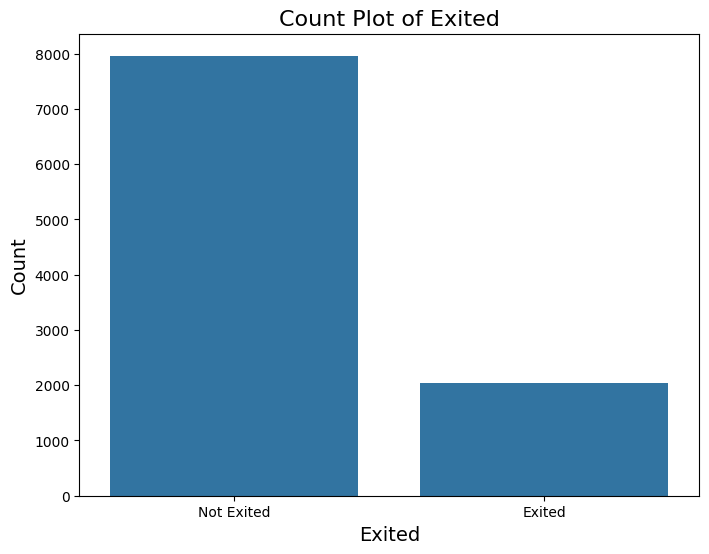

In [22]:
# Count Plot of our Y - Check the balance of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=raw_raw, x="Exited")
plt.title("Count Plot of Exited", fontsize=16)
plt.xlabel("Exited", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks([0, 1], labels=["Not Exited", "Exited"])
plt.show()

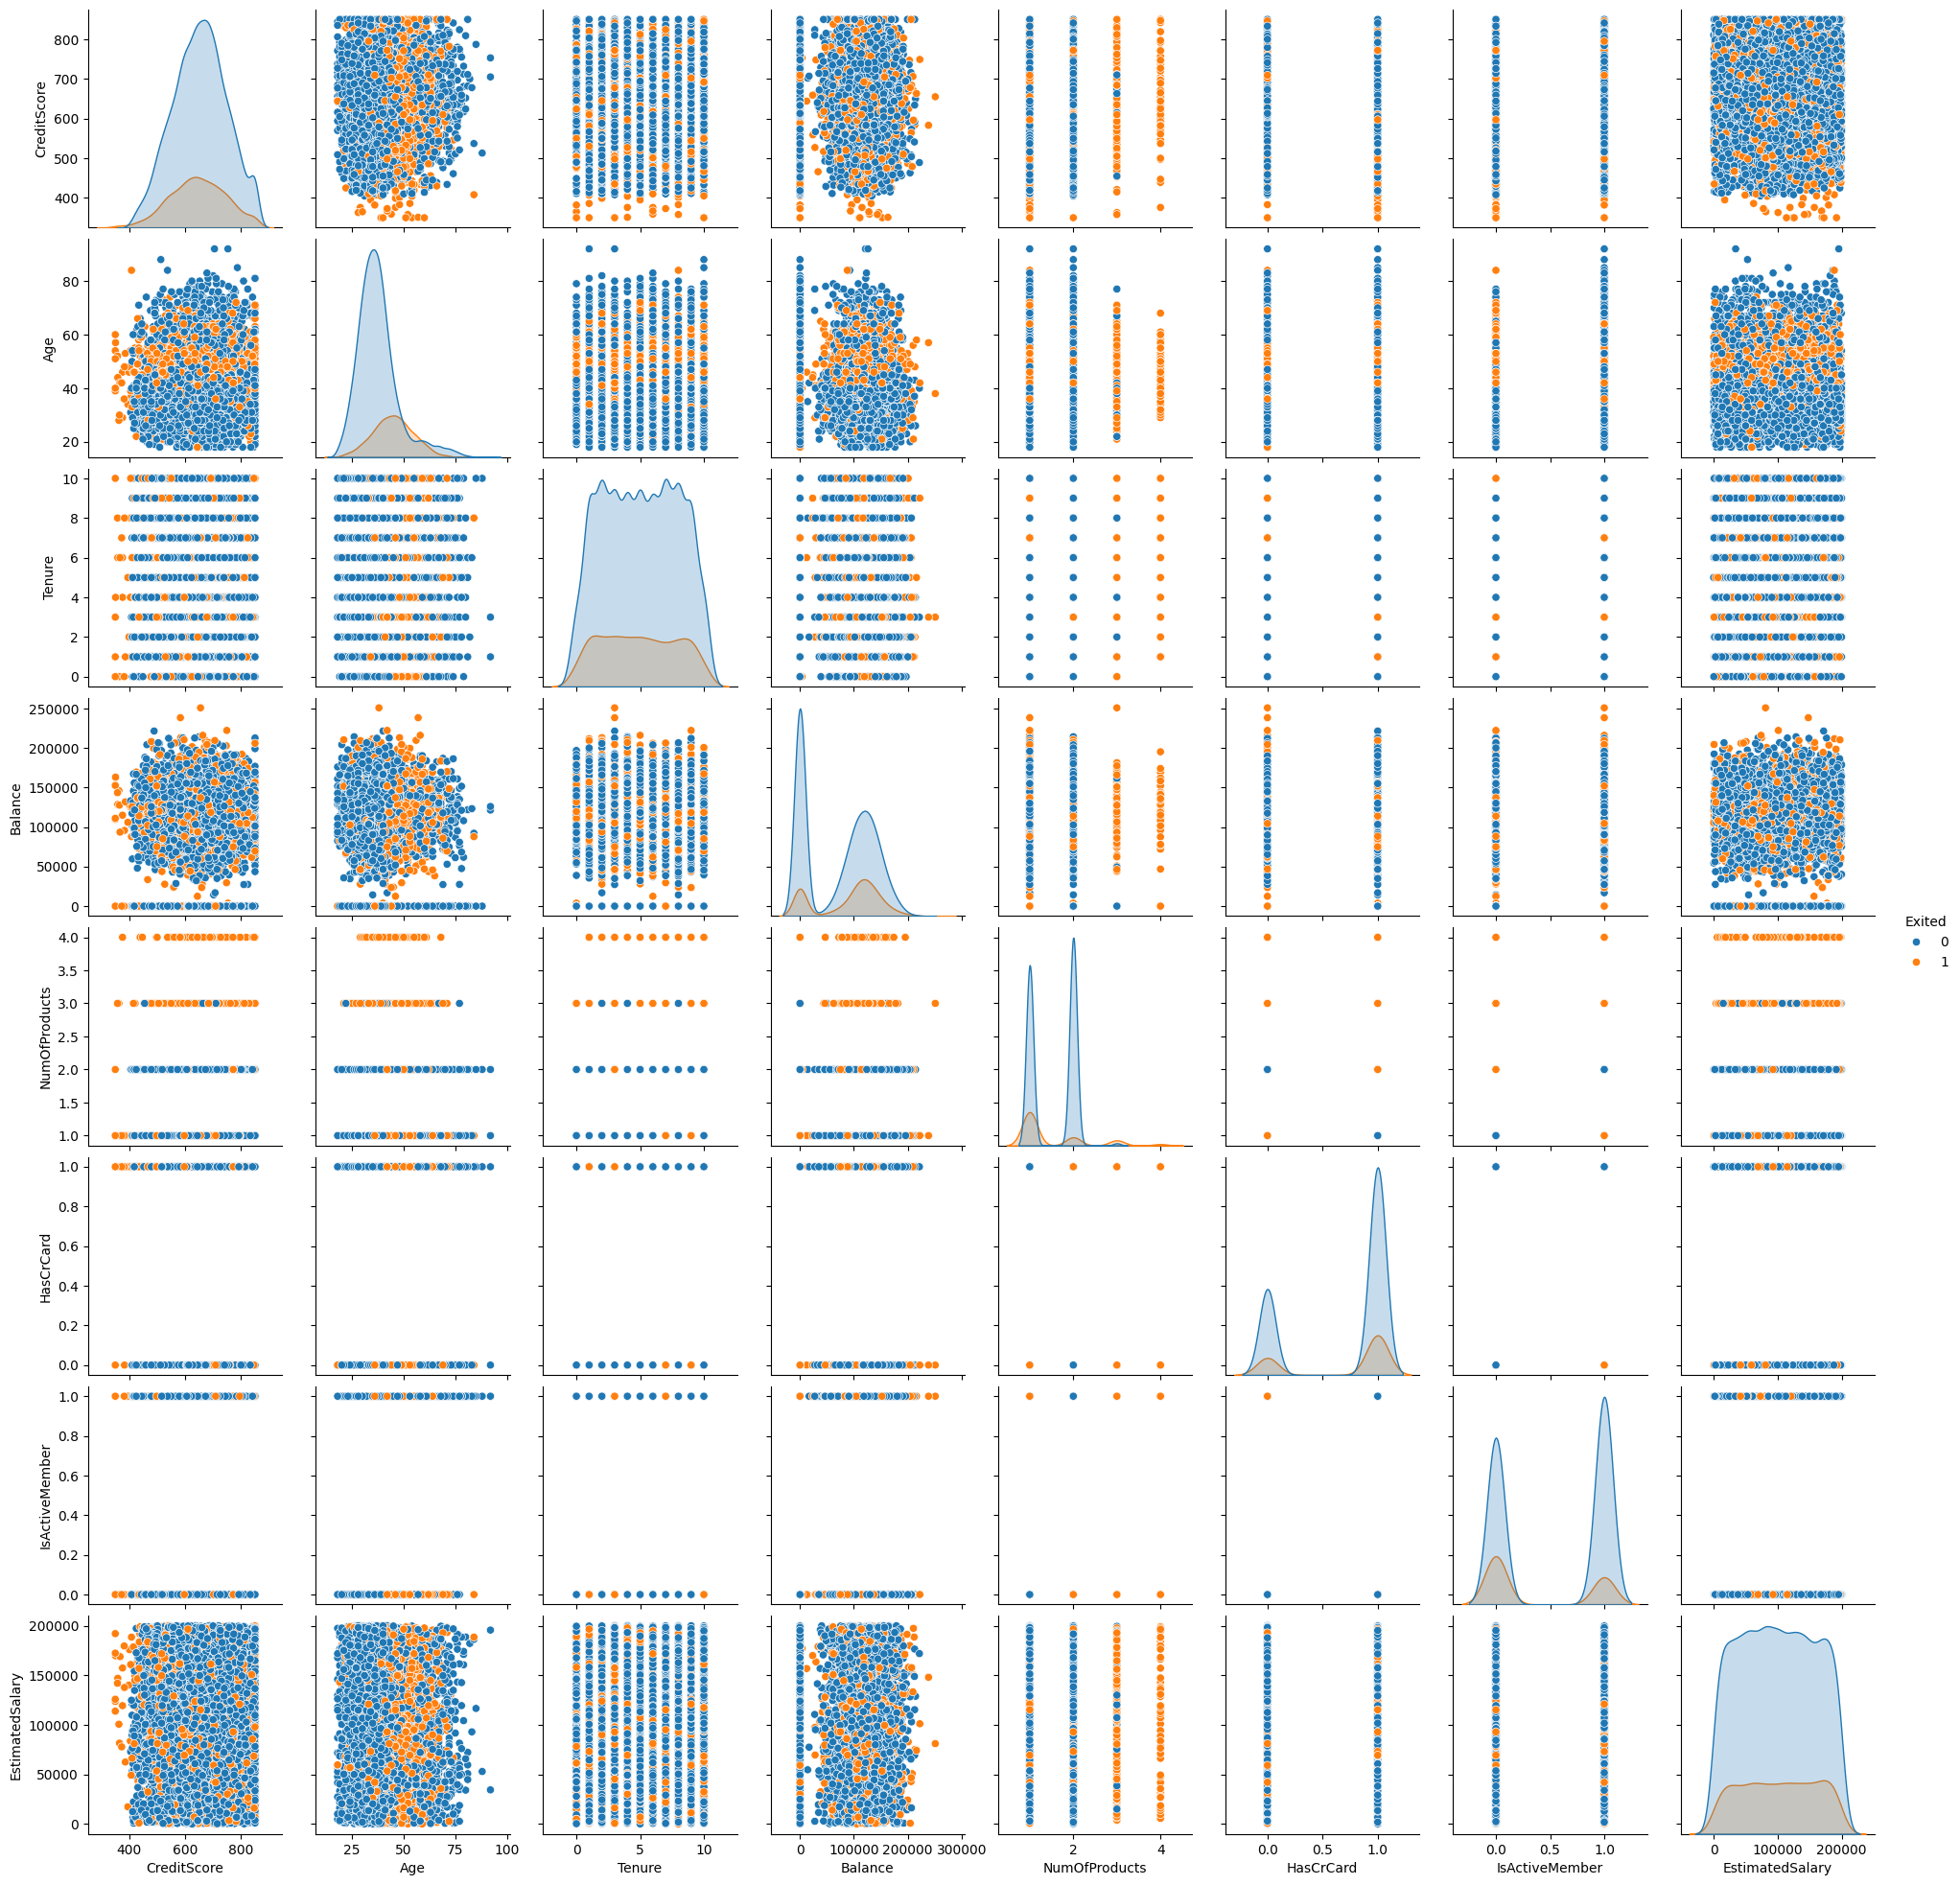

In [24]:
# limiting the data
raw_raw_v = raw_raw[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]

# Visualizing
g = sns.pairplot(raw_raw_v, hue = 'Exited')

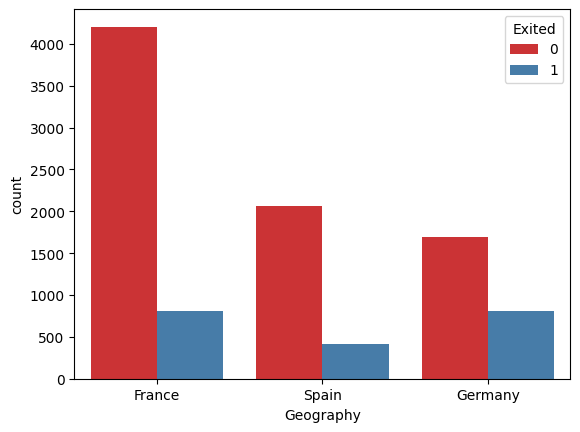

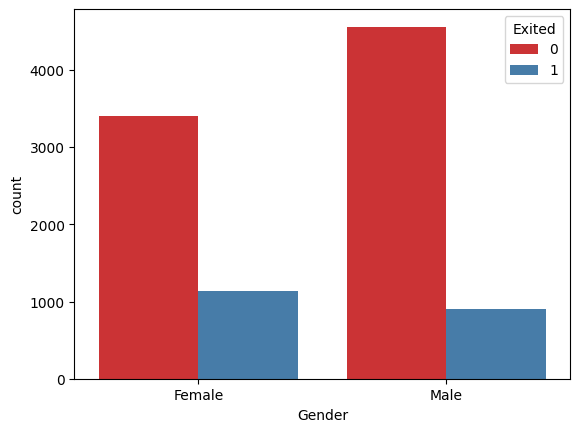

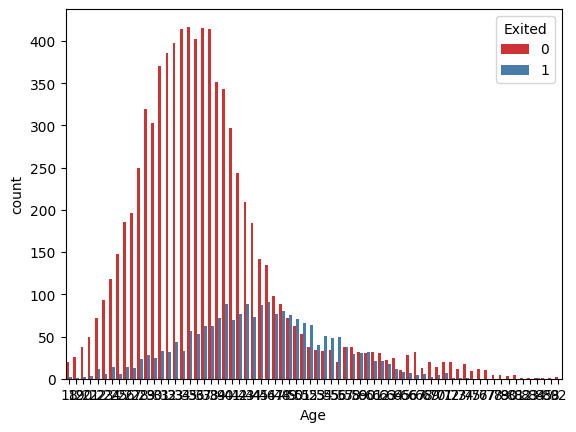

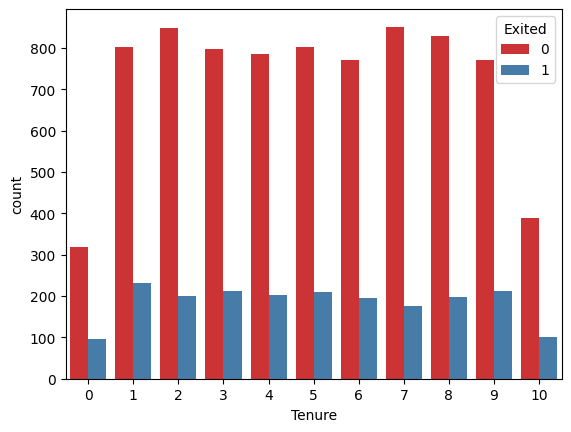

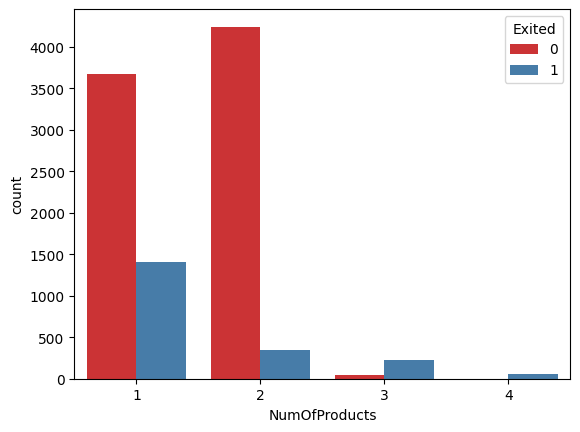

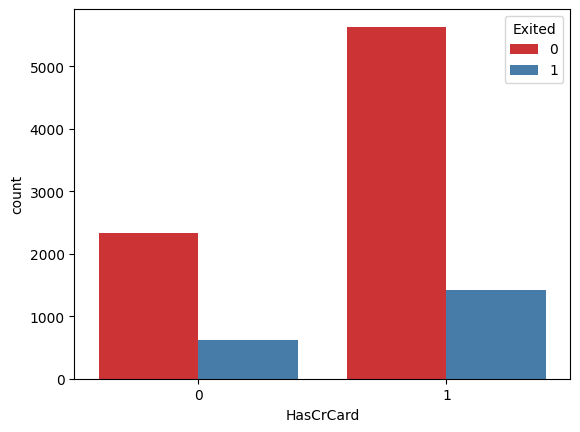

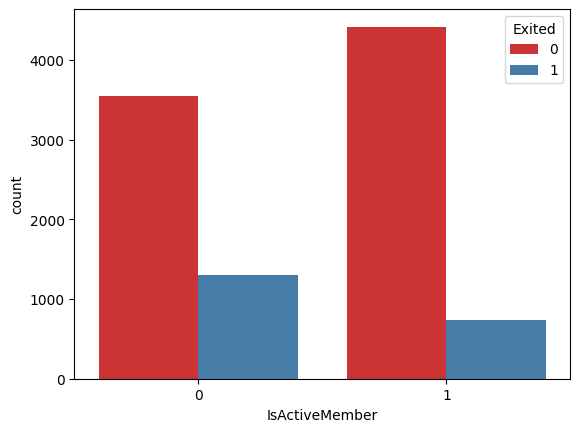

In [26]:
# Investigate all the features by our y

features = ['Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

for f in features:
    plt.figure()
    ax = sns.countplot(x=f, data=raw_raw_v, hue = 'Exited', palette="Set1")

The meadian is:  652.0


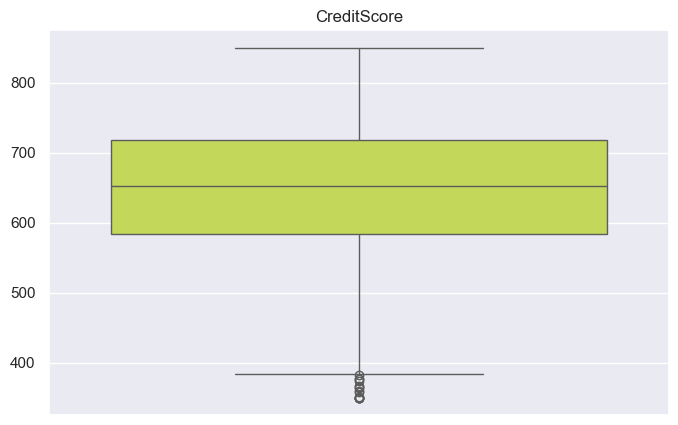

The meadian is:  37.0


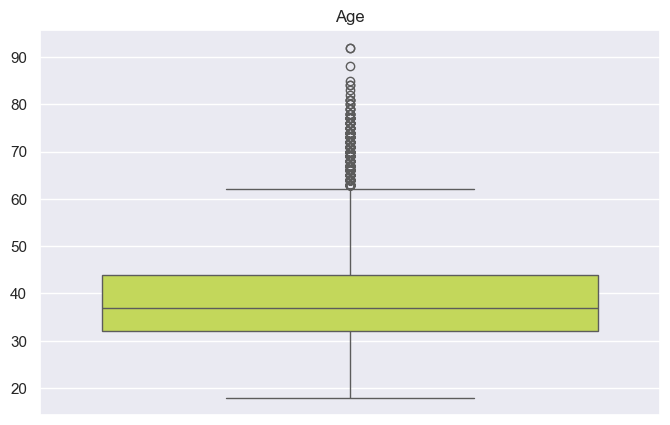

The meadian is:  5.0


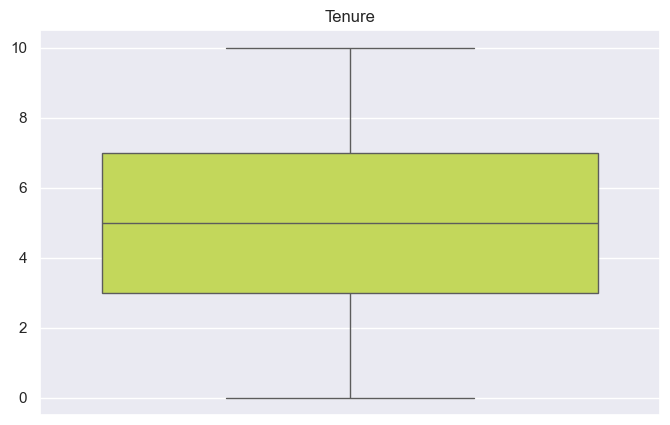

The meadian is:  97198.54000000001


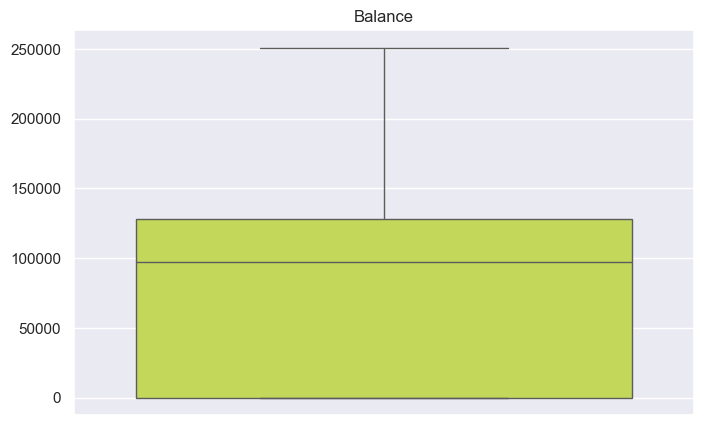

The meadian is:  1.0


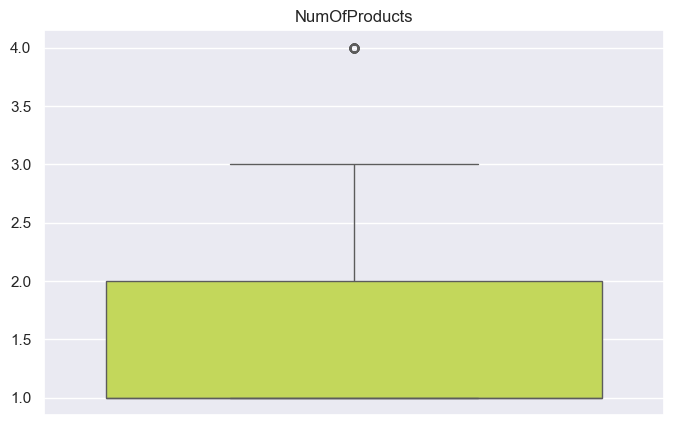

The meadian is:  1.0


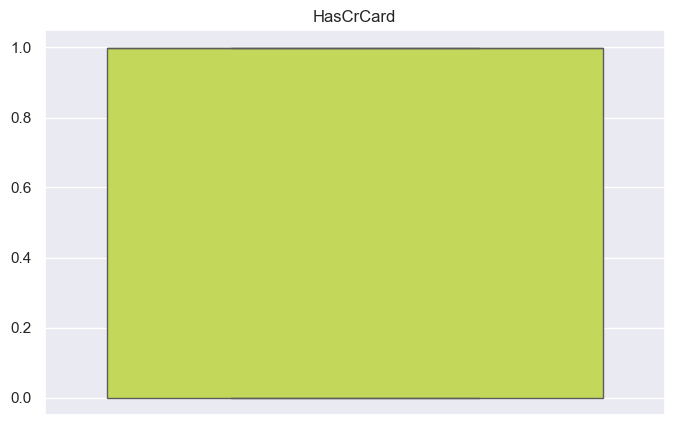

The meadian is:  1.0


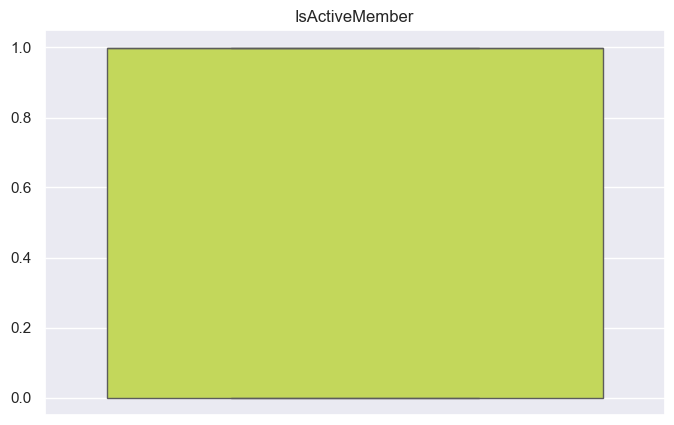

The meadian is:  100193.915


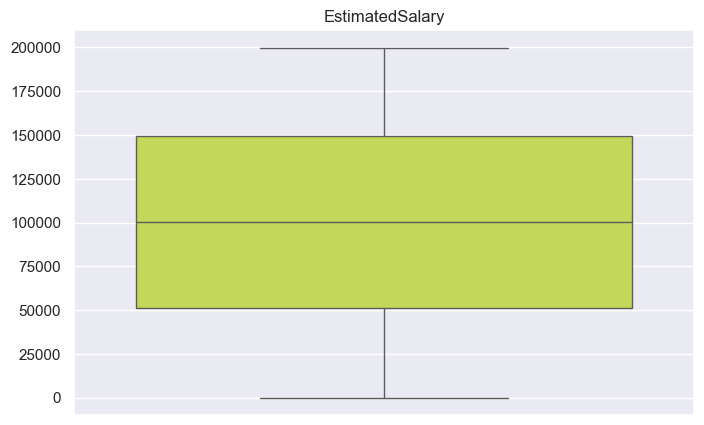

The meadian is:  0.0


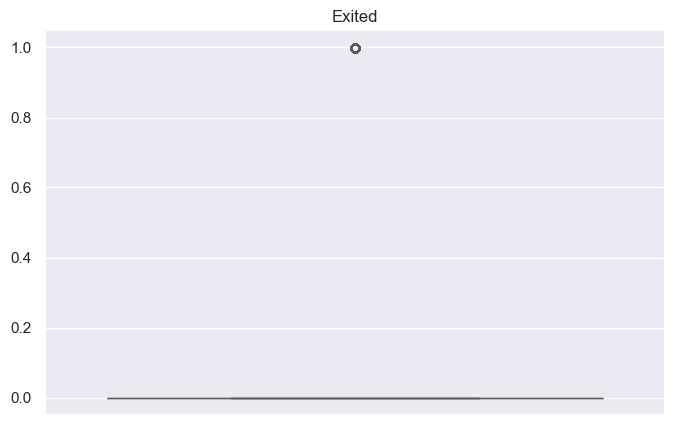

In [28]:
# Investigating the distribution of all Numerical values

# identifying all numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
n_variables = raw_raw_v.select_dtypes(include=numerics).columns

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,5)})

for c in n_variables:    
    x = raw_raw_v[c].values
    ax = sns.boxplot(x, color = '#D1EC46')
    print('The meadian is: ', raw_raw_v[c].median())
    plt.title(c)
    plt.show()

In [30]:
# Making categorical variables into numeric representation
new_raw_data = pd.get_dummies(raw_raw_v, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])

# Scaling our columns
scale_vars = ['CreditScore','EstimatedSalary','Tenure', 'Balance','Age', 'NumOfProducts']
scaler = MinMaxScaler()
new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars])
new_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,0.2,0.000000,0.000000,0.506735,1,True,False,False,True,False,False,True,False,True
1,0.516,0.310811,0.1,0.334031,0.000000,0.562709,0,False,False,True,True,False,True,False,False,True
2,0.304,0.324324,0.8,0.636357,0.666667,0.569654,1,True,False,False,True,False,False,True,True,False
3,0.698,0.283784,0.1,0.000000,0.333333,0.469120,0,True,False,False,True,False,True,False,True,False
4,1.000,0.337838,0.2,0.500246,0.000000,0.395400,0,False,False,True,True,False,False,True,False,True


# **4.Running XGBoost**

In [ ]:
pip install xgboost

In [ ]:
pip show xgboost

C:\Users\K Saketh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:26:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Accuracy: 0.96
Testing Accuracy: 0.86


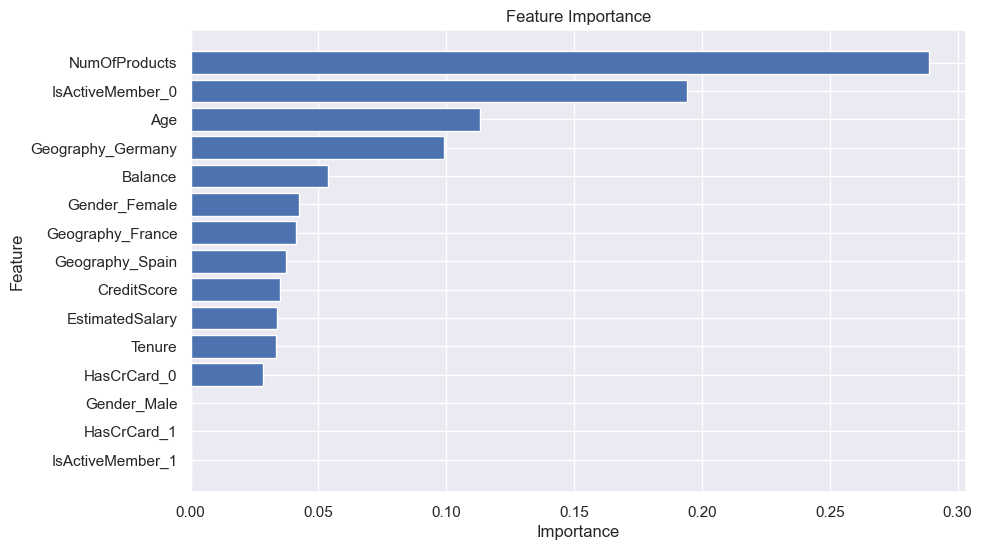


Feature Importance:


,Feature,Importance
4,NumOfProducts,0.288658
13,IsActiveMember_0,0.194039
1,Age,0.113240
7,Geography_Germany,0.099048
3,Balance,0.053883
9,Gender_Female,0.042302
6,Geography_France,0.041067
8,Geography_Spain,0.037478
0,CreditScore,0.034965
5,EstimatedSalary,0.033707


In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Features (X) and Target (y)
X = new_raw_data.drop(columns=["Exited"])
y = new_raw_data["Exited"]

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Training and Testing Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], align="center")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Displaying feature importance
print("\nFeature Importance:")
feature_importance


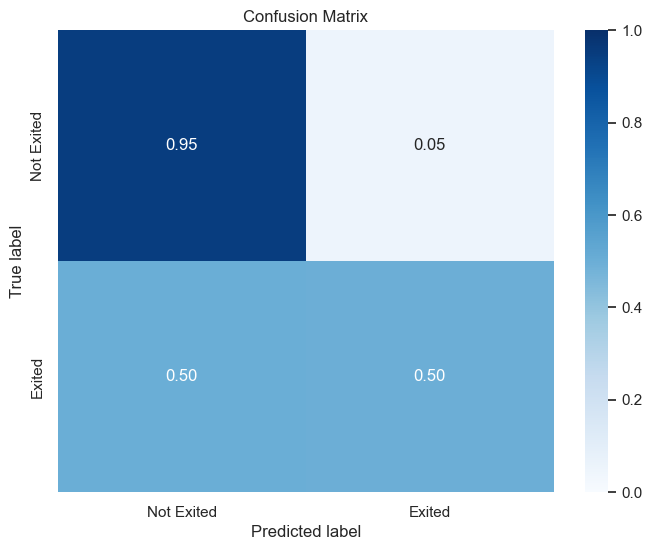

In [35]:
# Confusion Matrix function
def plot_confusion_matrix(cm, classes=None, title='Confusion Matrix'):
    """Plots a confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
plot_confusion_matrix(cm, classes=["Not Exited", "Exited"])

C:\Users\K Saketh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:26:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Accuracy: 0.97
Testing Accuracy: 0.85


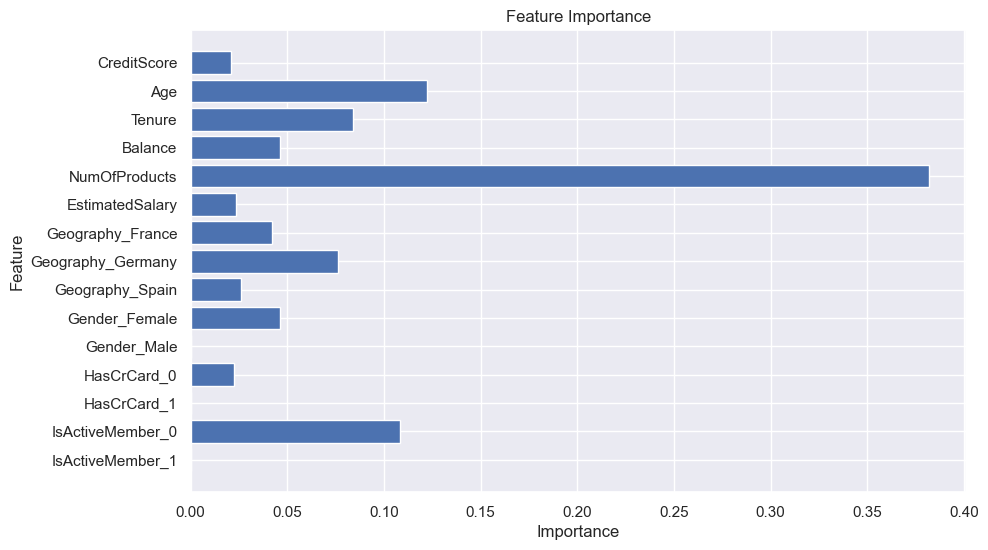

In [37]:
# 4. Re-Running XGBoost using SMOTE

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Applying SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = model.predict(X_train_resampled)
y_test_pred = model.predict(X_test)

# Training and Testing Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Plotting Feature Importance
feature_importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


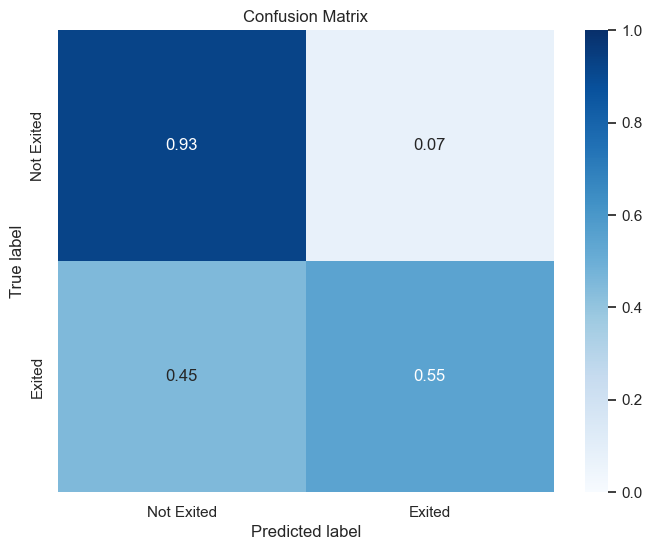

In [39]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
plot_confusion_matrix(cm, classes=["Not Exited", "Exited"])

# *Visualizing the tree*

C:\Users\K Saketh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


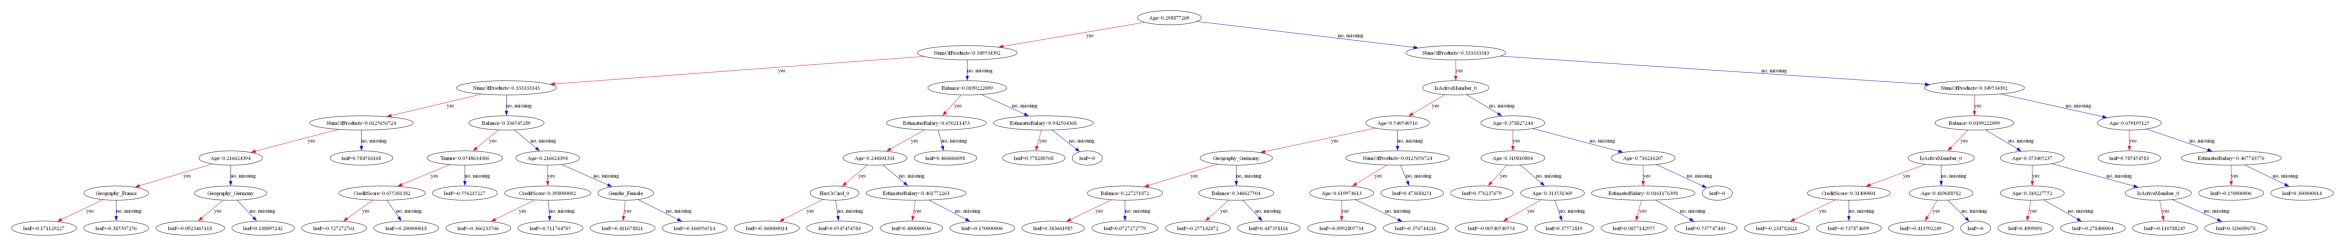

In [41]:
from PIL import Image
import xgboost as xgb


# Export the first tree in the ensemble to DOT format
dot_data = xgb.to_graphviz(model, num_trees=0)

# Save and display the tree
output_file = "xgboost_tree"
dot_data.render(output_file, format="png", view=False)  # Saves 'xgboost_tree.png'

# Display the tree image using PIL (for inline visualization in Jupyter or Python)
img = Image.open(f"{output_file}.png")
plt.figure(figsize=(30, 30))
plt.imshow(img)
plt.axis("off")
plt.show()

Training Accuracy: 0.78
Testing Accuracy: 0.79


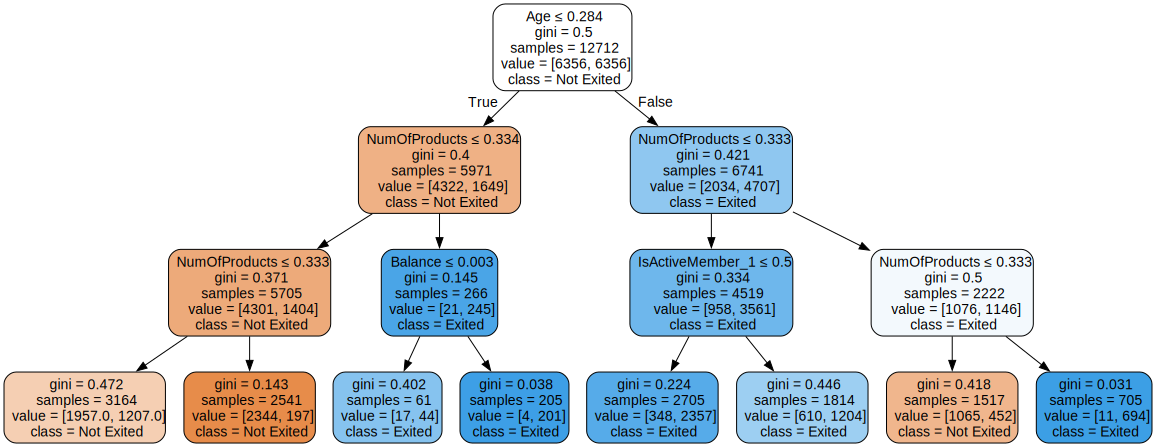

In [43]:
# Tree visual is not easy to read so we will train a simple DT to visual the tree:

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Train a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42, max_depth=3)  # Adjust max_depth for simplicity
dt.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_train_pred = dt.predict(X_train_resampled)
y_test_pred = dt.predict(X_test)

train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Export the decision tree to DOT format
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=new_raw_data.drop("Exited", axis=1).columns,
    class_names=["Not Exited", "Exited"],
    filled=True,
    rounded=True,
    special_characters=True
)

# Visualize the tree using Graphviz
graph = graphviz.Source(dot_data)
graph


#  **4. Hyperparameter Tuning**

In [45]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [3, 5, 7, 10],      # Maximum depth of a tree
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    "subsample": [0.6, 0.8, 1.0],    # Fraction of samples to grow trees
    "colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features for tree building
    "gamma": [0, 1, 5],              # Minimum loss reduction for split
    "reg_lambda": [1, 10, 50],       # L2 regularization term
}

# Initialize the base XGBoost classifier
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

# Apply RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring="f1",
    cv=3,  # 3-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and model
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Re-train the model with the best hyperparameters
best_model = random_search.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)
all_df_predict = best_model.predict(X)
all_df_predict_prob = best_model.predict_proba(X)

# Training and Testing Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance
# metrics: https://scikit-learn.org/1.5/modules/model_evaluation.html#scoring-parameter

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\K Saketh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:35:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 10, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


C:\Users\K Saketh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:35:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Accuracy: 0.95
Testing Accuracy: 0.85


,Feature,Importance
4,NumOfProducts,0.470494
1,Age,0.106685
14,IsActiveMember_1,0.100500
13,IsActiveMember_0,0.068868
7,Geography_Germany,0.052449
2,Tenure,0.035618
3,Balance,0.029498
9,Gender_Female,0.025509
6,Geography_France,0.019157
8,Geography_Spain,0.018522


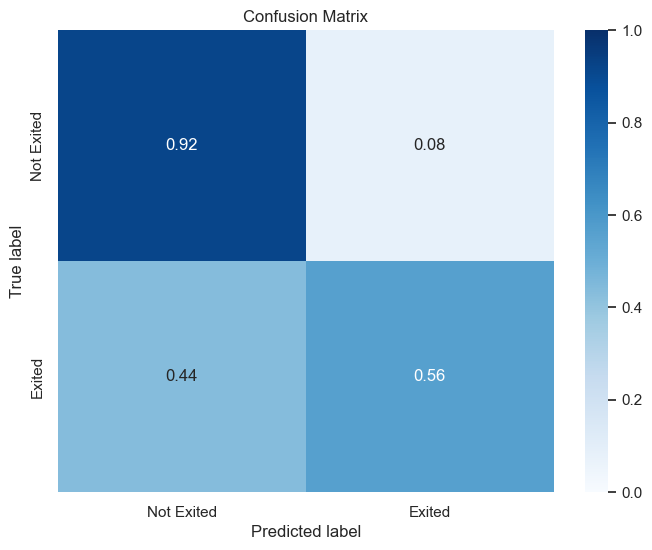

In [47]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
plot_confusion_matrix(cm, classes=["Not Exited", "Exited"])

# **5. Storing Models and Results**

In [68]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


In [70]:
# Adding the predictions back to the original dataset
raw_raw['Exited Prediction'] = all_df_predict
raw_raw['Exited Prediction Probability'] = all_df_predict_prob[:,1]

# Expoprting all the data with predictions
raw_raw.to_excel("bank_churn_data.xlsx")

In [72]:
# Storing the Feature Importances
feature_importance['Feature Importance Score'] = feature_importance['Importance'].round(4)
feature_importance.to_excel("feature_importance.xlsx")

In [74]:
# Save the best_model to a file
import pickle

with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved successfully!")

# saving the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

Model saved successfully!


# **6. Streamlit App**

In [83]:
from sklearn.preprocessing import MinMaxScaler
import streamlit as st
import pickle
import pandas as pd
import plotly.express as px

# Set Streamlit layout to wide
st.set_page_config(layout="wide")

# Load the trained model
with open('best_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load the MinMaxScaler
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Define the input features for the model
feature_names = [
    "CreditScore", "Age", "Tenure", "Balance", "NumOfProducts",
    "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain",
    "Gender_Female", "Gender_Male", "HasCrCard_0", "HasCrCard_1",
    "IsActiveMember_0", "IsActiveMember_1"
]

# Columns requiring scaling
scale_vars = ["CreditScore", "EstimatedSalary", "Tenure", "Balance", "Age", "NumOfProducts"]

# Updated default values
default_values = [
    600, 30, 2, 8000, 2, 60000,
    True, False, False, True, False, False, True, False, True
]

# Sidebar setup
try:
    st.sidebar.image("Pic 1.png", use_container_width=True)
except FileNotFoundError:
    st.sidebar.write("🧠 *Customer Churn Prediction*")

st.sidebar.header("User Inputs")

# Collect user inputs
user_inputs = {}
for i, feature in enumerate(feature_names):
    if feature in scale_vars:
        user_inputs[feature] = st.sidebar.number_input(
            feature, value=default_values[i], step=1 if isinstance(default_values[i], int) else 0.01
        )
    elif isinstance(default_values[i], bool):
        user_inputs[feature] = st.sidebar.checkbox(feature, value=default_values[i])
    else:
        user_inputs[feature] = st.sidebar.number_input(
            feature, value=default_values[i], step=1
        )

# Convert inputs to a DataFrame
input_data = pd.DataFrame([user_inputs])

# Apply MinMaxScaler to the required columns
input_data_scaled = input_data.copy()
input_data_scaled[scale_vars] = scaler.transform(input_data[scale_vars])

# App Header
try:
    st.image("Pic 2.png", use_container_width=True)
except FileNotFoundError:
    st.title("💼 Customer Churn Prediction")

# Page Layout
left_col, right_col = st.columns(2)

# Left Page: Feature Importance
with left_col:
    st.header("🔍 Feature Importance")
    try:
        feature_importance_df = pd.read_excel("feature_importance.xlsx", usecols=["Feature", "Feature Importance Score"])
        fig = px.bar(
            feature_importance_df.sort_values(by="Feature Importance Score", ascending=False),
            x="Feature Importance Score",
            y="Feature",
            orientation="h",
            title="Top Contributing Features",
            labels={"Feature Importance Score": "Importance", "Feature": "Features"},
            width=400,
            height=500
        )
        st.plotly_chart(fig)
    except Exception as e:
        st.error(f"Error loading feature importance chart: {e}")

# Right Page: Prediction
with right_col:
    st.header("📊 Prediction")
    if st.button("Predict"):
        try:
            probabilities = model.predict_proba(input_data_scaled)[0]
            prediction = model.predict(input_data_scaled)[0]
            prediction_label = "Churned" if prediction == 1 else "Retain"

            st.subheader(f"Predicted Value: {prediction_label}")
            st.write(f"Predicted Probability: {probabilities[1]:.2%} (Churn)")
            st.write(f"Predicted Probability: {probabilities[0]:.2%} (Retain)")
            st.markdown(f"### 🔔 Final Output: **{prediction_label}**")
        except Exception as e:
            st.error(f"Prediction failed: {e}")


2025-04-12 21:45:53.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 21:45:53.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 21:45:53.355 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 21:45:53.356 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 21:45:53.357 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 21:45:53.357 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 21:45:53.358 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-12 21:45:53.360 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar